# HW1: Классификация вредоносного ПО

**Задача:** бинарная классификация (`Class`: 0 — нейтральное ПО, 1 — вредоносное).  
**Сплит:** 60/20/20 со стратификацией.  
**Функция потерь:** `nn.BCELoss`.  
**Воспроизводимость:** зафиксирован `seed` = 42


In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt

SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# 1) Load dataset
DATA_PATH = "/content/cybersequrity.csv"  # положите файл рядом с ноутбуком
df = pd.read_csv(DATA_PATH)
df.head()


,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

In [4]:
X = df.drop(columns=["Class"]).values.astype(np.float32)
y = df["Class"].values.astype(np.float32)

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train).astype(np.float32)
X_val_s = scaler.transform(X_val).astype(np.float32)
X_test_s = scaler.transform(X_test).astype(np.float32)

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)
print("Class mean:", y_train.mean(), y_val.mean(), y_test.mean())


Shapes: (6000, 15) (2000, 15) (2000, 15)
Class mean: 0.5096667 0.5095 0.5095


In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 256
train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val_s, y_val),     batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test_s, y_test),   batch_size=batch_size, shuffle=False)


### Небольшой вывод
*  Данных немного, пока что не требуется их визуализация, в случае необходимости реализую в последующем.  
*  Разделил данные на трен, вал и тест выборку.
*  Стратифицировал и отскалировал.
*  Объявил класс для таблицы.
*  Размер батча выбрал из стандартных (64/128/256)
*  Признаков немного, сложная архитектура не требуется, можно воспльзоваться стандартной (Lin-ReLU).
*  Выход бинарный, в таком случае подойдет сигмоида.

In [6]:
class BaselineMLP(nn.Module):
    def __init__(self, features: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

baseline = BaselineMLP(features=X_train_s.shape[1]).to(device)
baseline


BaselineMLP(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
@torch.no_grad()
def eval_loss(model, loader, criterion):
    model.eval()
    total, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / n

def train_model(model, train_loader, val_loader, lr=1e-3, epochs=80, weight_decay=0.0, patience=12):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": []}
    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total, n = 0.0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        train_loss = total / n
        val_loss = eval_loss(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

def plot_losses(history, title="Loss"):
    plt.figure(figsize=(7,4))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("BCELoss")
    plt.grid(True)
    plt.legend()
    plt.show()

@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs, ys = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        p = model(xb).cpu().numpy().reshape(-1)
        probs.append(p)
        ys.append(yb.numpy().reshape(-1))
    return np.concatenate(probs), np.concatenate(ys)


Epoch 001 | train_loss=0.6822 | val_loss=0.6732
Epoch 010 | train_loss=0.5385 | val_loss=0.5319
Epoch 020 | train_loss=0.4792 | val_loss=0.4682
Epoch 030 | train_loss=0.4473 | val_loss=0.4449
Epoch 040 | train_loss=0.4365 | val_loss=0.4346
Epoch 050 | train_loss=0.4301 | val_loss=0.4365
Epoch 060 | train_loss=0.4158 | val_loss=0.4178
Epoch 070 | train_loss=0.4061 | val_loss=0.4080
Epoch 080 | train_loss=0.4000 | val_loss=0.3994


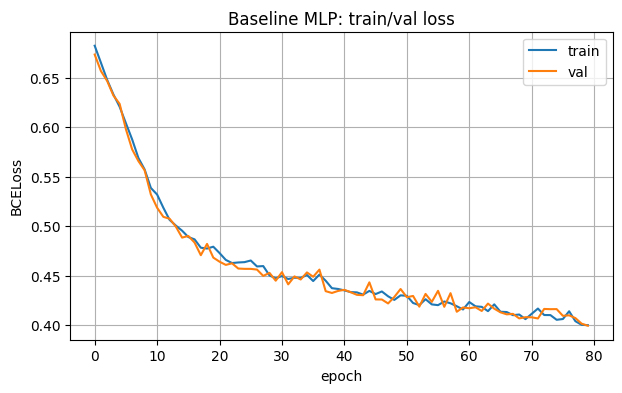

Baseline metrics:
accuracy: 0.813
f1      : 0.8070175438596491
roc_auc : 0.8891844956029127

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82       981
         1.0       0.85      0.77      0.81      1019

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



In [9]:
baseline = BaselineMLP(features=X_train_s.shape[1]).to(device)

baseline, hist_base = train_model(
    baseline, train_loader, val_loader,
    lr=2e-3,
    epochs=80,
    patience=12
)

plot_losses(hist_base, title="Baseline MLP: train/val loss")

probs_base, y_true = predict_proba(baseline, test_loader)
y_pred_base = (probs_base >= 0.5).astype(int)

print("Baseline metrics:")
print("accuracy:", accuracy_score(y_true, y_pred_base))
print("f1      :", f1_score(y_true, y_pred_base))
print("roc_auc :", roc_auc_score(y_true, probs_base))
print()
print(classification_report(y_true, y_pred_base, digits=2))


In [10]:
class ImprovedMLP(nn.Module):
    def __init__(self, features: int, p: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

for p in [0.1, 0.2, 0.3, 0.4]:
    model = ImprovedMLP(features=X_train_s.shape[1], p=p).to(device)
    model, hist = train_model(
        model, train_loader, val_loader,
        lr=1e-3,
        epochs=140,
        patience=20,
        weight_decay=1e-4,
    )
    probs, y_true = predict_proba(model, test_loader)
    y_pred = (probs >= 0.5).astype(int)
    print(f"p={p:.1f} | acc={accuracy_score(y_true,y_pred):.4f} | f1={f1_score(y_true,y_pred):.4f} | auc={roc_auc_score(y_true, probs):.4f}")


Epoch 001 | train_loss=0.6694 | val_loss=0.6621
Epoch 010 | train_loss=0.4611 | val_loss=0.4716
Epoch 020 | train_loss=0.4255 | val_loss=0.4241
Epoch 030 | train_loss=0.4004 | val_loss=0.4057
Epoch 040 | train_loss=0.4011 | val_loss=0.3966
Epoch 050 | train_loss=0.3851 | val_loss=0.3795
Epoch 060 | train_loss=0.3753 | val_loss=0.3686
Epoch 070 | train_loss=0.3791 | val_loss=0.3615
Epoch 080 | train_loss=0.3671 | val_loss=0.3563
Epoch 090 | train_loss=0.3764 | val_loss=0.3545
Epoch 100 | train_loss=0.3642 | val_loss=0.3561
Epoch 110 | train_loss=0.3550 | val_loss=0.3633
Epoch 120 | train_loss=0.3640 | val_loss=0.3593
Epoch 130 | train_loss=0.3590 | val_loss=0.3579
Epoch 140 | train_loss=0.3597 | val_loss=0.3470
p=0.1 | acc=0.8270 | f1=0.8291 | auc=0.9122
Epoch 001 | train_loss=0.6789 | val_loss=0.6589
Epoch 010 | train_loss=0.4955 | val_loss=0.4944
Epoch 020 | train_loss=0.4538 | val_loss=0.4436
Epoch 030 | train_loss=0.4326 | val_loss=0.4219
Epoch 040 | train_loss=0.4216 | val_loss=0.3

Epoch 001 | train_loss=0.6504 | val_loss=0.6450
Epoch 010 | train_loss=0.4711 | val_loss=0.4654
Epoch 020 | train_loss=0.4199 | val_loss=0.4357
Epoch 030 | train_loss=0.4094 | val_loss=0.3981
Epoch 040 | train_loss=0.3998 | val_loss=0.4079
Epoch 050 | train_loss=0.3945 | val_loss=0.4027
Epoch 060 | train_loss=0.3760 | val_loss=0.3780
Epoch 070 | train_loss=0.3720 | val_loss=0.3852
Epoch 080 | train_loss=0.3680 | val_loss=0.3800
Epoch 090 | train_loss=0.3703 | val_loss=0.3773
Epoch 100 | train_loss=0.3742 | val_loss=0.3588
Epoch 110 | train_loss=0.3568 | val_loss=0.3606
Epoch 120 | train_loss=0.3740 | val_loss=0.3657
Epoch 130 | train_loss=0.3580 | val_loss=0.3521
Epoch 140 | train_loss=0.3585 | val_loss=0.3490


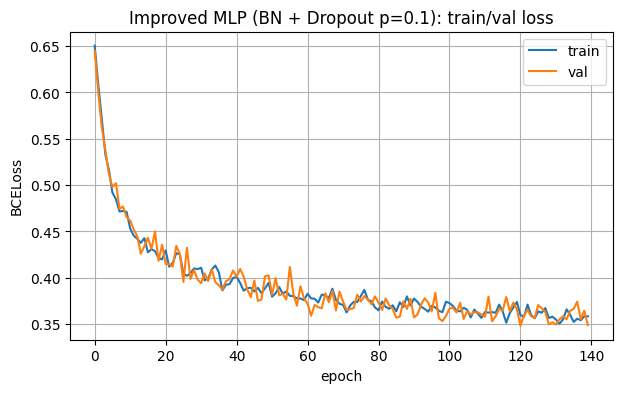

Improved metrics:
  accuracy: 0.8295
  f1      : 0.8253968253968254
  roc_auc : 0.9094753205907333

              precision    recall  f1-score   support

         0.0     0.8002    0.8695    0.8334       981
         1.0     0.8630    0.7910    0.8254      1019

    accuracy                         0.8295      2000
   macro avg     0.8316    0.8302    0.8294      2000
weighted avg     0.8322    0.8295    0.8293      2000



In [12]:
best_p = 0.1
improved = ImprovedMLP(features=X_train_s.shape[1], p=best_p).to(device)
improved, hist_imp = train_model(
    improved, train_loader, val_loader,
    lr=1e-3,
    epochs=140,
    patience=20,
    weight_decay=1e-4,
)

plot_losses(hist_imp, title=f"Improved MLP (BN + Dropout p={best_p}): train/val loss")

probs_imp, y_true = predict_proba(improved, test_loader)
y_pred_imp = (probs_imp >= 0.5).astype(int)

print("Improved metrics:")
print("  accuracy:", accuracy_score(y_true, y_pred_imp))
print("  f1      :", f1_score(y_true, y_pred_imp))
print("  roc_auc :", roc_auc_score(y_true, probs_imp))
print()
print(classification_report(y_true, y_pred_imp, digits=4))


## Выводы кратко

*   Выбрана стандартная архитектура для небольшой модели, данных и признаков немного, поэтому достаточно было выбрать 3-4 слоя.
*   В качестве оптимизатора использован базовый Adam
*   Данных немного, поэтому стоит осторожно выбирать параметр Dropout. В нашем случае лучше всего отработало значение p=0.1
*   Оптимальное количество эпох = ~100. Далее происходит нерациональное использование мощностей.




